# Discovering telomerase inhibitors with machine learning

Telomerase is the enzyme that repairs the protective caps of chromosomes. It is active in 90% of cancer cells, but not in most normal cells. Inhibiting telomerase could be a promising strategy for cancer treatment. In this notebook, we will build a machine learning model to predict whether a compound is a telomerase inhibitor.

We will focus on small molecules, excluding other types of compounds such as peptides. From a machine learning perspective, small molecules are easier to work than more complex compounds. From a drug discovery perspective, small molecules also have several advantages:

> Small molecule telomerase inhibitors are an attractive approach because it should be possible to intervene at multiple levels within the pathways that activate telomerase. Both known and unknown signaling pathways converging on either promoter are candidates for inhibition, and selective active site inhibitors also have considerable potential. Additionally, the telomere itself and various other targets that we discuss later in the chapter should be amenable to drugging. Small molecules are likely to demonstrate favorable bioavailability and frequently have the manufacturing advantages of cost-efficient, reproducible, and scalable synthesis. Importantly, they are also easily amenable to classic medicinal chemistry for lead optimization, and small molecule pharmacokinetics can easily be established in early trials ([Keith, 2008](https://www.researchgate.net/publication/278717635_Targeting_Telomerase_Therapeutic_Options_for_Cancer_Treatment)).

We have [built](data.ipynb) a dataset of biologically active compounds that could or are known to have telomerase-blocking activity. We will train a classifier on numerical features extracted from the SMILES structures of these compounds. We will use the best performing model to screen a separate chemical library for potential telomerase inhibitors, which could be used as leads for drug discovery.

In [1]:
%pip install -qU numpy pandas scikit-learn xgboost scipy matplotlib seaborn pubchempy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Data preprocessing

We will start by loading the dataset and performing basic preprocessing and exploratory analysis.

In [4]:
DATA_DIR = Path("data")

DATA_PATH = DATA_DIR / "data.csv"
SCREEN_PATH = DATA_DIR / "screen.csv"

In [5]:
data = pd.read_csv(DATA_PATH)
data

,name,smiles,label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,BIBR 1532,C/C(=C\C(=O)NC1=CC=CC=C1C(=O)O)/C2=CC3=CC=CC=C...,1,12.254174,12.254174,0.062600,-1.077657,0.687718,11.320000,331.371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Costunolide,C/C/1=C\CC/C(=C/[C@@H]2[C@@H](CC1)C(=C)C(=O)O2)/C,1,11.559391,11.559391,0.082500,-0.217658,0.362512,36.352941,232.323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EGCG,C1[C@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C(=...,1,12.721634,12.721634,0.052570,-1.181149,0.211503,17.090909,458.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BMS-582949,CCCNC(=O)C1=CN2C(=C1C)C(=NC=N2)NC3=C(C=CC(=C3)...,1,12.493042,12.493042,0.067470,-0.124329,0.559723,13.300000,406.490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Hypericin,CC1=CC(=O)C2=C(C3=C(C=C(C4=C3C5=C2C1=C6C(=CC(=...,1,13.357201,13.357201,0.043065,-0.483063,0.123350,12.789474,504.450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,Icatibant Acetate,CC(O)=O.NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)...,0,15.342188,15.342188,0.002684,-1.667813,0.019985,21.729167,1364.600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
3023,Plerixafor (AMD3100),C1CNCCNCCCN(CCNC1)CC2=CC=C(CN3CCCNCCNCCCNCC3)C=C2,0,3.625948,3.625948,1.039362,1.039362,0.353778,22.888889,502.796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,Sodium Hyaluronate,[Na+].CC(=O)NC1C(C(O)C(CO)OC1OC2C(O)C(O)C(O[*]...,0,11.570592,11.570592,0.000000,-1.759350,0.266010,45.814815,401.300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3025,Fosinopril Sodium,[Na+].CCC(=O)OC(O[P](=O)(CCCCC1=CC=CC=C1)CC(=O...,0,14.211981,14.211981,0.000000,-3.616382,0.107598,20.650000,585.654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We noticed that the dataset contains infinities and `NaN`s. We will clip the columns to the 1st and 99th percentiles to remove outliers and replace `NaN`s with 0s.

In [6]:
data.iloc[:, 3:] = data.iloc[:, 3:].clip(
  lower=data.iloc[:, 3:].quantile(0.01),
  upper=data.iloc[:, 3:].quantile(0.99),
  axis=1,
)
data

,name,smiles,label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,BIBR 1532,C/C(=C\C(=O)NC1=CC=CC=C1C(=O)O)/C2=CC3=CC=CC=C...,1,12.254174,12.254174,0.062600,-1.077657,0.687718,11.320000,331.371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Costunolide,C/C/1=C\CC/C(=C/[C@@H]2[C@@H](CC1)C(=C)C(=O)O2)/C,1,11.559391,11.559391,0.082500,-0.217658,0.362512,36.352941,232.323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EGCG,C1[C@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C(=...,1,12.721634,12.721634,0.052570,-1.181149,0.211503,17.090909,458.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BMS-582949,CCCNC(=O)C1=CN2C(=C1C)C(=NC=N2)NC3=C(C=CC(=C3)...,1,12.493042,12.493042,0.067470,-0.124329,0.559723,13.300000,406.490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Hypericin,CC1=CC(=O)C2=C(C3=C(C=C(C4=C3C5=C2C1=C6C(=CC(=...,1,13.357201,13.357201,0.043065,-0.483063,0.123350,12.789474,504.450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,Icatibant Acetate,CC(O)=O.NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)...,0,15.342188,15.342188,0.002684,-1.667813,0.026224,21.729167,1364.600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
3023,Plerixafor (AMD3100),C1CNCCNCCCN(CCNC1)CC2=CC=C(CN3CCCNCCNCCCNCC3)C=C2,0,3.625948,3.625948,1.000995,0.874735,0.353778,22.888889,502.796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,Sodium Hyaluronate,[Na+].CC(=O)NC1C(C(O)C(CO)OC1OC2C(O)C(O)C(O[*]...,0,11.570592,11.570592,0.000000,-1.759350,0.266010,45.814815,401.300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3025,Fosinopril Sodium,[Na+].CCC(=O)OC(O[P](=O)(CCCCC1=CC=CC=C1)CC(=O...,0,14.211981,14.211981,0.000000,-3.616382,0.107598,20.650000,585.654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="constant")
data.iloc[:, 3:] = pd.DataFrame(imputer.fit_transform(data.iloc[:, 3:]), columns=data.columns[3:], index=data.index)
data

,name,smiles,label,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,BIBR 1532,C/C(=C\C(=O)NC1=CC=CC=C1C(=O)O)/C2=CC3=CC=CC=C...,1,12.254174,12.254174,0.062600,-1.077657,0.687718,11.320000,331.371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Costunolide,C/C/1=C\CC/C(=C/[C@@H]2[C@@H](CC1)C(=C)C(=O)O2)/C,1,11.559391,11.559391,0.082500,-0.217658,0.362512,36.352941,232.323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EGCG,C1[C@H]([C@H](OC2=CC(=CC(=C21)O)O)C3=CC(=C(C(=...,1,12.721634,12.721634,0.052570,-1.181149,0.211503,17.090909,458.375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BMS-582949,CCCNC(=O)C1=CN2C(=C1C)C(=NC=N2)NC3=C(C=CC(=C3)...,1,12.493042,12.493042,0.067470,-0.124329,0.559723,13.300000,406.490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Hypericin,CC1=CC(=O)C2=C(C3=C(C=C(C4=C3C5=C2C1=C6C(=CC(=...,1,13.357201,13.357201,0.043065,-0.483063,0.123350,12.789474,504.450,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3022,Icatibant Acetate,CC(O)=O.NC(CCCNC(N)=N)C(=O)NC(CCCNC(N)=N)C(=O)...,0,15.342188,15.342188,0.002684,-1.667813,0.026224,21.729167,1364.600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
3023,Plerixafor (AMD3100),C1CNCCNCCCN(CCNC1)CC2=CC=C(CN3CCCNCCNCCCNCC3)C=C2,0,3.625948,3.625948,1.000995,0.874735,0.353778,22.888889,502.796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,Sodium Hyaluronate,[Na+].CC(=O)NC1C(C(O)C(CO)OC1OC2C(O)C(O)C(O[*]...,0,11.570592,11.570592,0.000000,-1.759350,0.266010,45.814815,401.300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3025,Fosinopril Sodium,[Na+].CCC(=O)OC(O[P](=O)(CCCCC1=CC=CC=C1)CC(=O...,0,14.211981,14.211981,0.000000,-3.616382,0.107598,20.650000,585.654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
data.describe().loc["std"].nlargest(3)

Ipc        1.161637e+23
BertzCT    5.729426e+02
MolWt      2.280084e+02
Name: std, dtype: float64

We see that the `Ipc` feature has an incredibly high standard deviation compared to the other features. We will standardize the features later, so we will not worry about this for now.

We will now drop the non-numeric columns and split the dataset into training and testing sets. Considering the extreme class imbalance, we will use stratified sampling to ensure that the training and testing sets have the same proportion of positive and negative examples.

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=["label", "name", "smiles"])
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=data["label"], random_state=RANDOM_STATE)
y_train.value_counts()

label
0    2381
1      40
Name: count, dtype: int64

Now we can proceed with dimensionality reduction and visualization. We will only perform PCA since we found that to give the best results while experimenting with different feature selection/extraction methods. We will, of course, standardize the features before applying PCA.

In [10]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.ensemble import RandomForestClassifier

# selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE))
# selector.fit(X_train, y_train)

# X_train = pd.DataFrame(selector.transform(X_train), index=X_train.index, columns=X_train.columns[selector.get_support()])
# X_test = pd.DataFrame(selector.transform(X_test), index=X_test.index, columns=X_test.columns[selector.get_support()])
# X_train

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
pca = PCA(random_state=RANDOM_STATE)

pipeline = Pipeline([
    ("scaler", scaler),
    ("pca", pca)
])
pipeline.fit(X_train)

X_train_pca = pd.DataFrame(pipeline.transform(X_train), index=X_train.index, columns=[f"PC{i}" for i in range(1, X_train.shape[1] + 1)])
X_test_pca = pd.DataFrame(pipeline.transform(X_test), index=X_test.index, columns=[f"PC{i}" for i in range(1, X_test.shape[1] + 1)])

We will keep 95% of the variance in the data, which will reduce the number of features from 1875 to 50.

In [12]:
threshold = 0.95
cum_expl_var = pd.Series(pipeline.named_steps["pca"].explained_variance_ratio_.cumsum())
n_components = (cum_expl_var >= threshold).argmax() + 1
print(f"We need {n_components} (out of {X_train.shape[1]}) components to explain {threshold:.0%} of the variance.")

We need 70 (out of 210) components to explain 95% of the variance.


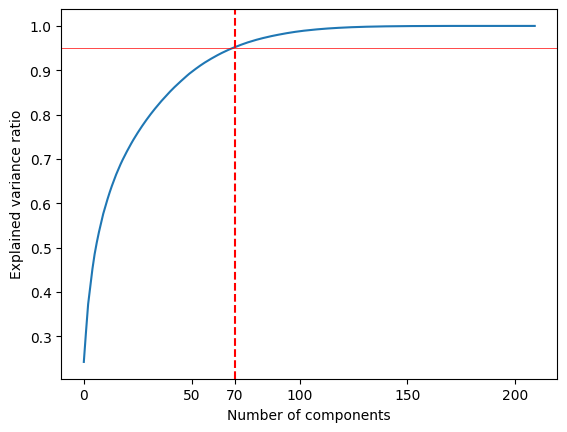

In [13]:
cum_expl_var.plot(xlabel="Number of components", ylabel="Explained variance ratio")
plt.axvline(n_components, color="red", linestyle="--")
plt.axhline(threshold, color="red", linestyle="-", linewidth=0.5)
plt.xticks(ticks=list(range(0, len(cum_expl_var) + 1, 50)) + [n_components])
plt.show()

In [14]:
# Select the first n_components
X_train_pca = X_train_pca.iloc[:, :n_components]
X_test_pca = X_test_pca.iloc[:, :n_components]
X_train_pca.shape

(2421, 70)

It helps to visualize the data in 2D to get a sense of the structure of the data. We will use t-SNE for this purpose, which attempts to preserve the local structure of the data by mapping similar data points in the high-dimensional space to nearby points in the lower-dimensional space.

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, n_iter=1500, random_state=RANDOM_STATE)
X_train_tsne = pd.DataFrame(tsne.fit_transform(X_train_pca), index=X_train.index, columns=["t-SNE1", "t-SNE2"])

<Axes: xlabel='t-SNE1', ylabel='t-SNE2'>

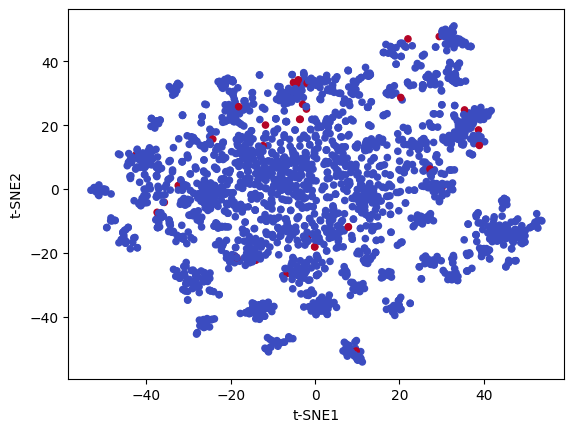

In [16]:
X_train_tsne.plot.scatter(x="t-SNE1", y="t-SNE2", c=y_train, cmap="coolwarm", colorbar=False)

We wee some patterns in the data (e.g., positive examples missing from the central region of the plot), but the data is still quite scattered. This is somewhat of a good sign, as it suggests that our dataset is reasonably diverse (both the negative and the positive examples) and not trivially separable. We can verify this by performing clustering on the data.

Dist (k= 2): [2134  287]
Dist (k= 3): [1044 1220  157]
Dist (k= 4): [ 171 1099  152  999]
Dist (k= 5): [ 131 1052  203  985   50]
Dist (k= 6): [123 862 121 766  50 499]
Dist (k= 7): [102 844  98 210  48 346 773]
Dist (k= 8): [ 99 744 377 192 166  49 709  85]
Dist (k= 9): [ 99 708 154 194  27  50 381  91 717]
Dist (k=10): [ 99 678 151 200  27  49 371  98 694  54]
Dist (k=11): [ 99 638 146 207  27  50 311  86 646  41 170]
Dist (k=12): [ 88 585 141 362  27  47 143  71 355  41 168 393]
Dist (k=13): [ 85 579 141 301  27  45 158  69 321  42 166 365 122]
Dist (k=14): [ 91 462 139 260  27  42 120 105 433  43 159 178 297  65]
Dist (k=15): [ 89 530 136 247  27  40  92  30 389  43 158 184 260  71 125]
Dist (k=16): [ 95 510 156 210  27  38  88  19 390  41 149 175 232  68  85 138]
Dist (k=17): [ 95 411 119  70  26  38  84  19 483  41 173 182 226  66  81 135 172]
Dist (k=18): [ 95 410 118  69  26  38  82  19 482  41 174 181 233  60  78 135 171   9]
Dist (k=19): [ 95 407 128  67  26  26  81  24 461  

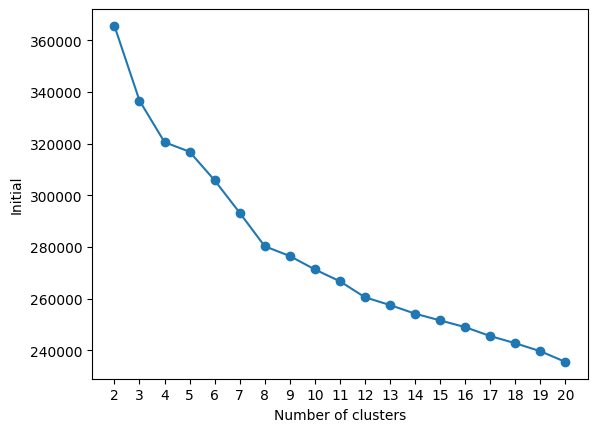

In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []

# kmeans_data = X_train_pca[y_train == 0]
# kmeans_data = X_train_pca[y_train == 1]
kmeans_data = X_train_pca

ks = range(2, 21)
for k in ks:
  kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
  kmeans.fit(kmeans_data)
  inertia.append(kmeans.inertia_)
  silhouette.append(silhouette_score(kmeans_data, kmeans.labels_))

  print(f"Dist ({k=:>2}): {np.unique(kmeans.predict(kmeans_data), return_counts=True)[1]}")

plt.plot(ks, inertia, marker="o")
plt.xticks(ks)
plt.xlabel("Number of clusters")
plt.ylabel("Initial")
plt.show()

There is no elbow point, which suggests that the data is not easily separable. This is consistent with the t-SNE plot, as well as the rather low silhouette scores:

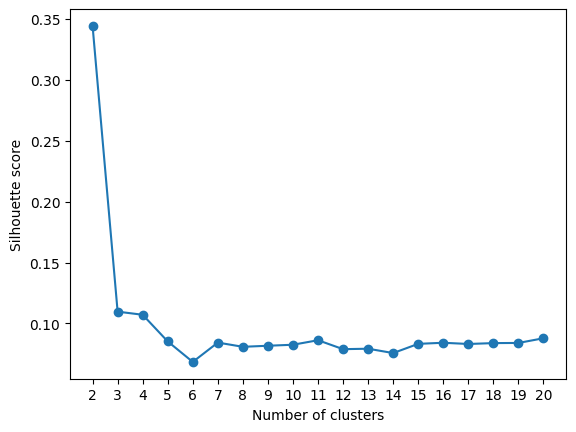

In [18]:
plt.plot(ks, silhouette, marker="o")
plt.xticks(ks)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

We see the same trend when considering the positive and negative examples separately, which you can check by rerunning the code with the appropriate lines uncommented.

With data preprocessing complete, we can now move on to building and evaluating machine learning models to predict telomerase inhibitors.

## Model selection

We will consider the following models:

- Support vector machine
- Random forest
- XGBoost

These models are known to perform well on a wide range of classification tasks, especially complex ones like this.

We will first train the `scikit-learn` gradient boosting model, which is a simpler version of XGBoost, to get a baseline performance. Keeping in mind that accuracy is not a good metric for imbalanced datasets like ours, we will mainly focus on the precision, recall, and F1 score (the harmonic mean of precision and recall) of the models.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
)
model.fit(X_train_pca, y_train)

GradientBoostingClassifier(random_state=42)

In [20]:
from sklearn.metrics import classification_report

y_pred_train = model.predict(X_train_pca)
print(classification_report(y_train, y_pred_train, zero_division=np.nan))

y_pred_test = model.predict(X_test_pca)
print(classification_report(y_test, y_pred_test, zero_division=np.nan))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2381
           1       1.00      0.93      0.96        40

    accuracy                           1.00      2421
   macro avg       1.00      0.96      0.98      2421
weighted avg       1.00      1.00      1.00      2421

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       596
           1       0.20      0.10      0.13        10

    accuracy                           0.98       606
   macro avg       0.59      0.55      0.56       606
weighted avg       0.97      0.98      0.98       606



We see that the gradient boosting model performs quite poorly on the test set, managing to detect only 1 out of 10 positive examples while making many incorrect guesses. Hence, we should adjust our expectations for the other models accordingly.

We will now perform hyperparameter tuning using grid search with 5-fold cross-validation. We will use the F1 score as the scoring metric for the grid search. In reality, we care slightly more about precision than recall, because we wouldn't want to waste time and resources on false positives. However, we still want a sensitive enough model that can detect as many telomerase inhibitors as possible, so we will go ahead with the F1 score as the main evaluation metric and a wide range of hyperparameters to explore (including the `class_weight` parameter to account for the class imbalance).

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

param_grid = {
  "svm": {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [2, 3, 4],
    "class_weight": ["balanced", None],
  },
  "rf": {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "criterion": ["gini", "entropy"],
    "class_weight": ["balanced", None],
    "max_features": ["sqrt", "log2"],
  },
  "xgb": {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
  }
}

models = {
  "svm": SVC(random_state=RANDOM_STATE),
  "rf": RandomForestClassifier(random_state=RANDOM_STATE),
  "xgb": XGBClassifier(random_state=RANDOM_STATE),
}

def tune_model(model, param_grid, X=X_train_pca, y=y_train):
  grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring=["f1", "precision", "recall"],
    refit="f1",
    n_jobs=-1,
  )
  grid_search.fit(X, y)

  return grid_search

In [ ]:
results = {name: tune_model(model, param_grid[name]) for name, model in models.items()}

In [23]:
for name, result in results.items():
  print(f"{name}: {result.best_params_}")
  print(f"{name}: {result.best_score_}")

svm: {'C': 0.1, 'class_weight': 'balanced', 'degree': 3, 'kernel': 'poly'}
svm: 0.21242236024844718
rf: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}
rf: 0.06713286713286713
xgb: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
xgb: 0.04444444444444444


The performance of all the models leaves much to be desired. However, it explains why we're getting better results with PCA than by using random forests to select features. Clearly, random forests cannot be trusted to identify the most important features for this dataset, so an unsupervised method like PCA is probably more reliable.

Somewhat surprisingly, the SVM outperforms the random forest model and even XGBoost. On the other hand, SVMs are known to perform well on high-dimensional data (with the right kernel, of course, which in this case is the polynomial kernel), so this is not entirely unexpected.

In [24]:
print("Test\n====\n")

print("SVM")
print(classification_report(y_test, results["svm"].best_estimator_.predict(X_test_pca), zero_division=np.nan))

print("Random Forest")
print(classification_report(y_test, results["rf"].best_estimator_.predict(X_test_pca), zero_division=np.nan))

print("XGBoost")
print(classification_report(y_test, results["xgb"].best_estimator_.predict(X_test_pca), zero_division=np.nan))

Test
====

SVM
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       596
           1       0.16      0.30      0.21        10

    accuracy                           0.96       606
   macro avg       0.57      0.64      0.59       606
weighted avg       0.97      0.96      0.97       606

Random Forest
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       596
           1       0.19      0.30      0.23        10

    accuracy                           0.97       606
   macro avg       0.59      0.64      0.61       606
weighted avg       0.97      0.97      0.97       606

XGBoost
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       596
           1        nan      0.00      0.00        10

    accuracy                           0.98       606
   macro avg       0.98      0.50      0.50       606
weighted avg       0.98      0.98    

In [25]:
print("Train\n=====\n")

print("SVM")
print(classification_report(y_train, results["svm"].best_estimator_.predict(X_train_pca), zero_division=np.nan))

print("Random Forest")
print(classification_report(y_train, results["rf"].best_estimator_.predict(X_train_pca), zero_division=np.nan))

print("XGBoost")
print(classification_report(y_train, results["xgb"].best_estimator_.predict(X_train_pca), zero_division=np.nan))

Train
=====

SVM
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2381
           1       0.35      0.70      0.47        40

    accuracy                           0.97      2421
   macro avg       0.67      0.84      0.73      2421
weighted avg       0.98      0.97      0.98      2421

Random Forest
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2381
           1       0.36      0.78      0.49        40

    accuracy                           0.97      2421
   macro avg       0.68      0.88      0.74      2421
weighted avg       0.99      0.97      0.98      2421

XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2381
           1       1.00      0.88      0.93        40

    accuracy                           1.00      2421
   macro avg       1.00      0.94      0.97      2421
weighted avg       1.00      1.00  

Judging by the train vs. test F1 score of the XGBoost model, it seems to be overfitting the training data. We can plot the confusion matrices to see where the models are making mistakes:

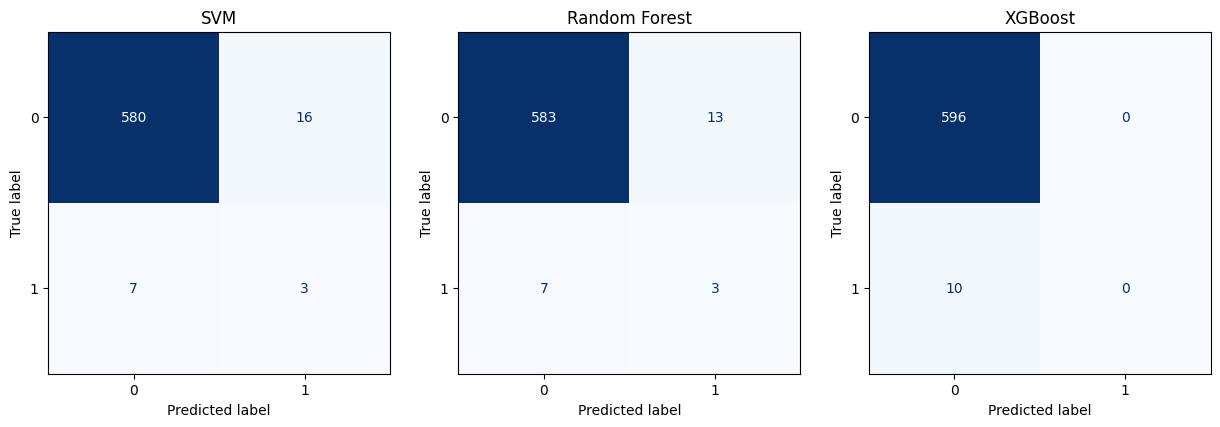

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay.from_estimator(
  results["svm"].best_estimator_,
  X_test_pca,
  y_test,
  cmap="Blues",
  colorbar=False,
  ax=axs[0],
)
axs[0].set_title("SVM")

ConfusionMatrixDisplay.from_estimator(
  results["rf"].best_estimator_,
  X_test_pca,
  y_test,
  cmap="Blues",
  colorbar=False,
  ax=axs[1],
)
axs[1].set_title("Random Forest")

ConfusionMatrixDisplay.from_estimator(
  results["xgb"].best_estimator_,
  X_test_pca,
  y_test,
  cmap="Blues",
  colorbar=False,
  ax=axs[2],
)
axs[2].set_title("XGBoost")

plt.show()

On the test set, the random forest model performs better than the SVM, achieving marginally higher precision. However, the cross-validation scores suggest that the SVM is more consistent and generalizes better to unseen data. We will use the SVM model to screen the chemical library for potential telomerase inhibitors.

Before we proceed, it will be interesting to visualize where the SVM model is making mistakes. We will again use t-SNE to visualize the predictions of the SVM model on the test set:

In [27]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=1500, random_state=RANDOM_STATE)
X_test_tsne = pd.DataFrame(tsne.fit_transform(X_test_pca), index=X_test.index, columns=["t-SNE1", "t-SNE2"])

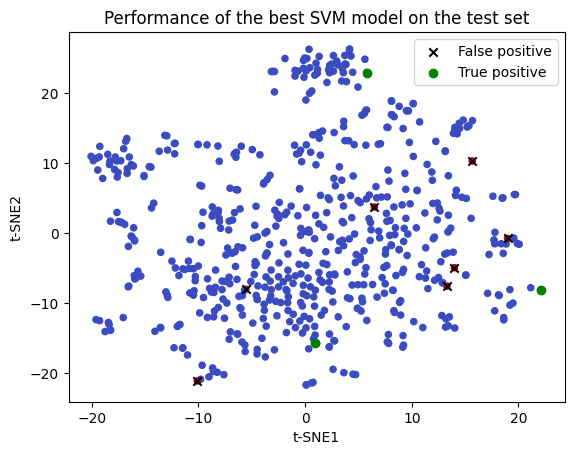

In [28]:
X_test_tsne.plot.scatter(x="t-SNE1", y="t-SNE2", c=y_test, cmap="coolwarm", colorbar=False, title="Performance of the best SVM model on the test set")

y_test_pred = results["svm"].best_estimator_.predict(X_test_pca)
plt.scatter(X_test_tsne[(y_test == 1) & (y_test != y_test_pred)]["t-SNE1"], X_test_tsne[(y_test == 1) & (y_test != y_test_pred)]["t-SNE2"], c="black", marker="x", label="False positive")
plt.scatter(X_test_tsne[(y_test == 1) & (y_test == y_test_pred)]["t-SNE1"], X_test_tsne[(y_test == 1) & (y_test == y_test_pred)]["t-SNE2"], c="green", marker="o", label="True positive")
plt.legend()
plt.show()

It's hard to make sense of the plot without having the decision boundary but we're unlikely to learn much from it anyway. For the sake of completeness, we will now retrain the SVM model on the entire dataset and use it to screen a different dataset for potential telomerase inhibitors.

## Screening and conclusion

We will load the chemical library and preprocess it in the same way as the training data. We will then use the SVM model to predict whether each compound is a telomerase inhibitor. Of course, we will not be able to verify the predictions, but we can at least get an idea of the potential telomerase inhibitors in the library.

In [29]:
screen_data = pd.read_csv(SCREEN_PATH)
screen_data

,smiles,name,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Nc1nc2[nH]nnc2c(=O)[nH]1,Azaguanine-8,10.962593,10.962593,0.049583,-0.387731,0.430316,10.545455,152.117,148.085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CN(C)C(=N)NC(=N)N,Metformin hydrochloride,7.067778,7.067778,0.113426,-0.214167,0.248785,8.222222,129.167,118.079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(=O)OCC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=...,Isoflupredone acetate,16.884033,16.884033,0.085680,-1.997379,0.679307,47.066667,420.477,391.245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CCCc1ncc(C[n+]2ccccc2C)c(N)n1,Amprolium hydrochloride,5.985117,5.985117,0.587225,0.587225,0.830783,10.555556,243.334,224.182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,Hydrochlorothiazide,11.633654,11.633654,0.014270,-4.069104,0.654458,18.235294,297.745,289.681,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,CN(C)CC[C@H](CSc1ccccc1)Nc1ccc(S(=O)(=O)NC(=O)...,ABT-737,13.350173,13.350173,0.140221,-4.426475,0.057731,14.035714,813.446,768.086,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1678,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)ccc12,Fisetin,12.082041,12.082041,0.087182,-0.653875,0.510622,10.857143,286.239,276.159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,CC1(C)CCC(c2ccc(Cl)cc2)=C(CN2CCN(c3ccc(C(=O)NS...,Navitoclax,14.177964,14.177964,0.001862,-6.052872,0.104649,18.338462,974.634,919.194,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,Cc1c(-c2ccc(N3CCc4cccc(C(=O)Nc5nc6ccccc6s5)c4C...,A1331852,13.522989,13.522989,0.025570,-1.061671,0.185260,24.187500,658.828,620.524,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [30]:
screen_descriptors = screen_data.drop(columns=["name", "smiles"])
screen_descriptors = screen_descriptors.clip(
  lower=screen_descriptors.quantile(0.01),
  upper=screen_descriptors.quantile(0.99),
  axis=1,
)
screen_descriptors = pd.DataFrame(imputer.transform(screen_descriptors), columns=screen_descriptors.columns, index=screen_descriptors.index)
screen_descriptors_pca = pd.DataFrame(pipeline.transform(screen_descriptors), index=screen_descriptors.index, columns=[f"PC{i}" for i in range(1, screen_descriptors.shape[1] + 1)]).iloc[:, :n_components]
screen_descriptors_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70
0,-6.435865,-1.165214,3.444639,-4.015028,-3.586400,-0.972146,-1.330753,4.754884,-1.929031,-0.872592,...,0.408643,0.564708,-1.028492,1.442688,0.114789,-0.602954,0.098020,-0.572900,-0.401485,-0.684371
1,-7.223818,2.634289,2.219258,-4.102018,0.398284,2.820498,0.264503,2.276806,0.564471,0.903378,...,-0.185200,-1.076500,-0.154501,0.300433,1.113195,-0.221557,2.550697,0.815038,0.813637,0.055411
2,1.980497,4.538316,-6.554852,0.743492,-2.567119,-1.304740,-4.504168,0.035021,2.961456,0.391823,...,-0.903900,0.078594,0.314244,-0.210039,0.259596,-0.753362,0.152769,-0.170915,0.261304,0.248686
3,-5.380038,-1.842459,0.095300,-1.456840,-1.683904,0.274600,1.390494,2.500195,-1.538728,-1.201845,...,0.749690,-0.384907,-0.333796,0.571784,0.036849,-0.940803,-0.243061,-0.494785,0.398642,-1.059548
4,-3.728620,0.304802,1.917586,-2.877411,-1.171531,-1.276258,0.473734,0.027714,4.291011,1.587343,...,0.108182,0.869715,0.381031,0.294130,0.879353,0.703216,0.252689,0.497328,-0.583170,-0.131496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,9.305070,-9.837719,-0.443627,2.005294,-0.441083,0.364780,1.460171,-3.615066,3.215915,0.665244,...,0.402348,-0.507237,-0.997598,0.048516,-1.193661,-0.958192,1.629432,-1.901187,1.595384,0.969078
1678,-3.157728,-1.204468,1.523460,-0.373145,6.847182,-3.987455,-4.480237,1.324709,-1.404899,1.800692,...,-0.444657,0.518785,-0.418380,-0.171931,0.329601,0.282524,0.216190,-0.149364,0.204443,0.372099
1679,12.579355,-8.781502,-1.834660,2.354436,-2.889661,-1.398139,4.083722,-3.961008,6.569989,2.217482,...,-1.307355,0.233143,-0.221776,0.244149,-0.811210,-2.531757,1.711749,-0.374385,1.911767,0.525103
1680,7.813546,-6.343183,-4.741265,2.409620,-4.448208,-1.000367,-1.520703,1.694106,-0.749610,0.830364,...,-1.313976,1.186002,0.121576,0.347491,0.469063,0.580393,0.107885,-0.181348,1.594031,-0.602466


In [31]:
screen_data["label"] = results["svm"].best_estimator_.predict(screen_descriptors_pca)
screen_data["label"].value_counts()

label
0    1656
1      26
Name: count, dtype: int64

In [32]:
screen_data[screen_data["label"] == 1]

,smiles,name,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,label
49,CN1CCc2cccc3c2[C@H]1Cc1ccc(O)c(O)c1-3.CN1CCc2c...,R(-) Apomorphine hydrochloride hemihydrate,10.260322,10.260322,0.016275,-0.037993,0.216641,20.350000,534.656,500.384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
224,CN1CCc2c(c3ccccc3n2Cc2ccccc2)C1.CN1CCc2c(c3ccc...,"Mebhydroline 1,5-naphtalenedisulfonate",2.520833,2.520833,0.972620,0.972620,0.227285,15.285714,552.766,512.446,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
260,c1ccc2[nH]c(-c3cscn3)nc2c1,Tiabendazole,4.443796,4.443796,0.840231,0.840231,0.657283,10.857143,201.254,194.198,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
321,NCCNCCNCCNCCN,Tetraethylenepentamine pentahydrochloride,5.319533,5.319533,0.706404,0.706404,0.248876,10.615385,189.307,166.123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,1
530,Cc1cc(C=Cc2ccc3cc(N(C)C)ccc3[n+]2C)c(C)n1-c1cc...,Pyrvinium pamoate,2.308375,2.308375,1.180201,1.180201,0.143965,11.482759,765.062,708.614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
544,CN(C/C=C/c1ccccc1)Cc1cccc2ccccc12,Naftifine hydrochloride,2.334537,2.334537,0.942575,0.942575,0.639079,11.545455,287.406,266.238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
612,Nc1c2ccccc2nc2ccccc12,Aminacrine,6.114630,6.114630,0.815926,0.815926,0.558615,10.933333,194.237,184.157,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
642,C=C1CC[C@H](O)C/C1=C/C=C1\CCC[C@]2(C)[C@@H]([C...,Cholecalciferol,10.023784,10.023784,0.171925,-0.171925,0.499104,37.642857,384.648,340.296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
673,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@@H](O)C2,Cianidanol,10.180343,10.180343,0.142543,-0.933439,0.509593,20.619048,290.271,276.159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
679,O=C(c1cc(O)c(O)c(O)c1)c1ccc(O)c(O)c1O,Exifone,12.089798,12.089798,0.223898,-0.858266,0.357576,10.400000,278.216,268.136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


While we're not able to perform wet lab experiments to verify the predictions, a quick literature search reveals that many of the compounds have aging-related effects, and some, like [myricetin](https://pubmed.ncbi.nlm.nih.gov/25965778/), are indeed telomerase inhibitors! This suggests that our model has some predictive power and could be used to guide further experiments. While not all of the compounds are telomerase inhibitors, our model has reduced the search space from 1656 to just 26, which is a significant improvement.

To summarize, we have built a machine learning model to predict telomerase inhibitors and used it to screen a chemical library for potential telomerase inhibitors. Despite its modest performance, the model has identified several compounds that could be used as leads for drug discovery.

The poor performance of the models suggests the need for more data and perhaps better features. In particular, we could consider using more advanced featurization techniques like graph neural networks to capture deeper structural information about the compounds. We could also try more advanced models like deep neural networks to see if they can learn better representations of the existing molecular fingerprints.

However, the fact that simple traditional machine learning models can be useful in computational drug discovery is already a promising result. And more than anything, it's exciting to be able to contribute to medical research from the comfort of our laptops.

## Acknowledgments

This project is heavily inspired by the [Discovery of senolytics using machine learning](https://www.nature.com/articles/s41467-023-39120-1) paper by Vanessa Smer-Barreto et al. The authors used machine learning to find potential senolytics (compounds that selectively kill aging cells) and then validated the predictions in vitro, discovering three powerful new senolytics.

The simplicity of their ML pipeline was quite surprising, hardly requiring any domain-specific knowledge or machine learning skills what we covered in this course, so we wanted to replicate their work with a different target. We did not use any of their code, but our analysis naturally converged to theirs. However, we would like to thank the authors for sharing their data, which included the Prestwick and LOPAC libraries that we used for our screening, saving us the trouble of purchasing them.